<a href="https://colab.research.google.com/github/duybluemind1988/Data-science/blob/master/Pytorch/Pytorch_multiclass_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Winequality-red

https://towardsdatascience.com/pytorch-tabular-multiclass-classification-9f8211a123ab

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler

from sklearn.preprocessing import MinMaxScaler,StandardScaler    
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

## Prepare data

In [ ]:
df = pd.read_csv("/content/drive/My Drive/Data/winequality-red.csv")
print(df.shape)
df.head()

(1599, 12)


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


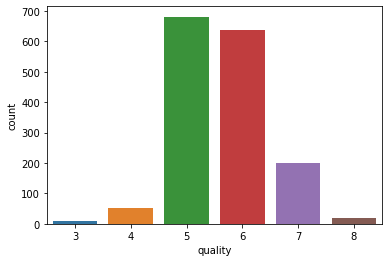

In [ ]:
sns.countplot(x = 'quality', data=df)

In [ ]:
class2idx = {
    3:0,
    4:1,
    5:2,
    6:3,
    7:4,
    8:5
}

idx2class = {v: k for k, v in class2idx.items()}

df['quality'].replace(class2idx, inplace=True)

In [ ]:
X = df.iloc[:, 0:-1]
y = df.iloc[:, -1]

In [ ]:
# Split into train+val and test
X_trainval, X_test, y_trainval, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=69)

# Split train into train-val
X_train, X_val, y_train, y_val = train_test_split(X_trainval, y_trainval, test_size=0.1, stratify=y_trainval, random_state=21)

scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

X_train, y_train = np.array(X_train), np.array(y_train)
X_val, y_val = np.array(X_val), np.array(y_val)
X_test, y_test = np.array(X_test), np.array(y_test)

In [ ]:
def get_class_distribution(obj):
    count_dict = {
        "rating_3": 0,
        "rating_4": 0,
        "rating_5": 0,
        "rating_6": 0,
        "rating_7": 0,
        "rating_8": 0,
    }
    
    for i in obj:
        if i == 0: 
            count_dict['rating_3'] += 1
        elif i == 1: 
            count_dict['rating_4'] += 1
        elif i == 2: 
            count_dict['rating_5'] += 1
        elif i == 3: 
            count_dict['rating_6'] += 1
        elif i == 4: 
            count_dict['rating_7'] += 1  
        elif i == 5: 
            count_dict['rating_8'] += 1              
        else:
            print("Check classes.")
            
    return count_dict

Text(0.5, 1.0, 'Class Distribution in Test Set')

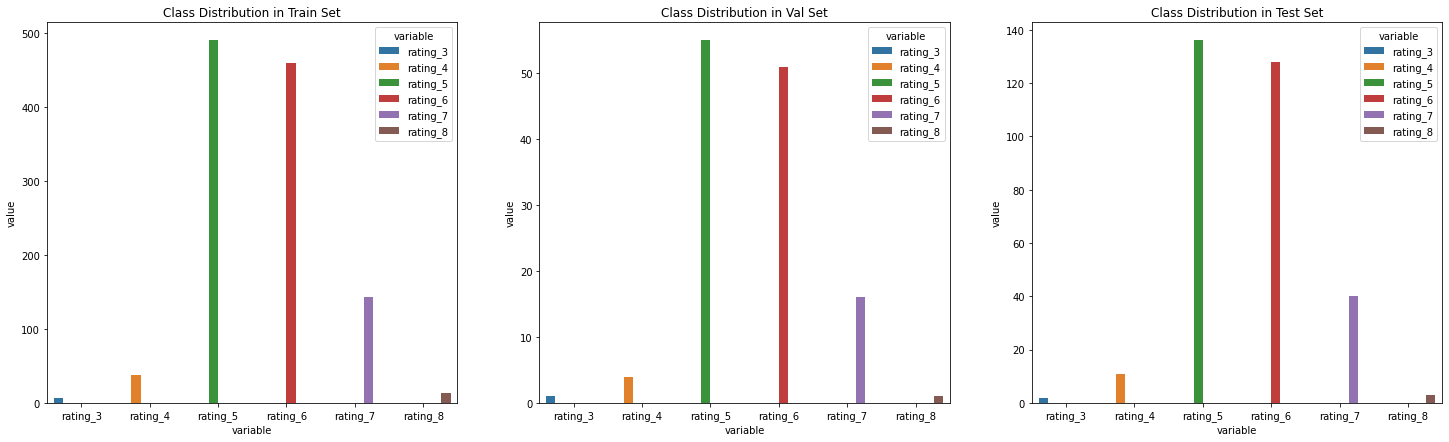

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(25,7))
# Train
sns.barplot(data = pd.DataFrame.from_dict([get_class_distribution(y_train)]).melt(), x = "variable", y="value", hue="variable",  ax=axes[0]).set_title('Class Distribution in Train Set')
# Validation
sns.barplot(data = pd.DataFrame.from_dict([get_class_distribution(y_val)]).melt(), x = "variable", y="value", hue="variable",  ax=axes[1]).set_title('Class Distribution in Val Set')
# Test
sns.barplot(data = pd.DataFrame.from_dict([get_class_distribution(y_test)]).melt(), x = "variable", y="value", hue="variable",  ax=axes[2]).set_title('Class Distribution in Test Set')

## Neural Network

In [ ]:
class ClassifierDataset(Dataset):
    
    def __init__(self, X_data, y_data):
        self.X_data = X_data
        self.y_data = y_data
        
    def __getitem__(self, index):
        return self.X_data[index], self.y_data[index]
        
    def __len__ (self):
        return len(self.X_data)

train_dataset = ClassifierDataset(torch.from_numpy(X_train).float(), torch.from_numpy(y_train).long())
val_dataset = ClassifierDataset(torch.from_numpy(X_val).float(), torch.from_numpy(y_val).long())
test_dataset = ClassifierDataset(torch.from_numpy(X_test).float(), torch.from_numpy(y_test).long())

Weighted Sampling

Because there’s a class imbalance, we use stratified split to create our train, validation, and test sets.

While it helps, it still does not ensure that each mini-batch of our model see’s all our classes. We need to over-sample the classes with less number of values. To do that, we use the WeightedRandomSampler.

First, we obtain a list called target_list which contains all our outputs. This list is then converted to a tensor and shuffled.

In [ ]:
target_list = []
for _, t in train_dataset:
    target_list.append(t)
    
target_list = torch.tensor(target_list)
target_list = target_list[torch.randperm(len(target_list))]
print(target_list.shape)
target_list

torch.Size([1151])


tensor([0, 3, 3,  ..., 4, 5, 3])

Then, we obtain the count of all classes in our training set. We use the reciprocal of each count to obtain it’s weight. Now that we’ve calculated the weights for each class, we can proceed.

In [ ]:
get_class_distribution(y_train).values()

dict_values([7, 38, 490, 459, 143, 14])

In [ ]:
class_count = [i for i in get_class_distribution(y_train).values()]
class_weights = 1./torch.tensor(class_count, dtype=torch.float) 
print(class_weights)

tensor([0.1429, 0.0263, 0.0020, 0.0022, 0.0070, 0.0714])


WeightedRandomSampler expects a weight for each sample. We do that using as follows.

In [ ]:
class_weights_all = class_weights[target_list]
print(class_weights_all.shape)
class_weights_all

torch.Size([1151])


tensor([0.1429, 0.0022, 0.0022,  ..., 0.0070, 0.0714, 0.0022])

Finally, let’s initialize our WeightedRandomSampler. We’ll call this in our dataloader below.

In [ ]:
weighted_sampler = WeightedRandomSampler(
    weights=class_weights_all,
    num_samples=len(class_weights_all),
    replacement=True
)
weighted_sampler

Model Parameters

Before we proceed any further, let’s define a few parameters that we’ll use down the line.

In [ ]:
EPOCHS = 300
BATCH_SIZE = 16
LEARNING_RATE = 0.0007
NUM_FEATURES = len(X.columns)
NUM_CLASSES = 6

Dataloader

Let’s now initialize our dataloaders.

For train_dataloader we’ll use batch_size = 64 and pass our sampler to it. Note that we’re not using shuffle=True in our train_dataloader because we’re already using a sampler. These two are mutually exclusive.

For test_dataloader and val_dataloader we’ll use batch_size = 1 .

In [ ]:
train_loader = DataLoader(dataset=train_dataset,
                          batch_size=BATCH_SIZE,
                          sampler=weighted_sampler
)
val_loader = DataLoader(dataset=val_dataset, batch_size=1)
test_loader = DataLoader(dataset=test_dataset, batch_size=1)

Define Neural Net Architecture

Let’s define a simple 3-layer feed-forward network with dropout and batch-norm.

In [ ]:
class MulticlassClassification(nn.Module):
    def __init__(self, num_feature, num_class):
        super(MulticlassClassification, self).__init__()
        
        self.layer_1 = nn.Linear(num_feature, 512)
        self.layer_2 = nn.Linear(512, 128)
        self.layer_3 = nn.Linear(128, 64)
        self.layer_out = nn.Linear(64, num_class) 
        
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=0.2)
        self.batchnorm1 = nn.BatchNorm1d(512)
        self.batchnorm2 = nn.BatchNorm1d(128)
        self.batchnorm3 = nn.BatchNorm1d(64)
        
    def forward(self, x):
        x = self.layer_1(x)
        x = self.batchnorm1(x)
        x = self.relu(x)
        
        x = self.layer_2(x)
        x = self.batchnorm2(x)
        x = self.relu(x)
        x = self.dropout(x)
        
        x = self.layer_3(x)
        x = self.batchnorm3(x)
        x = self.relu(x)
        x = self.dropout(x)
        
        x = self.layer_out(x)
        
        return x

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


Initialize the model, optimizer, and loss function. Transfer the model to GPU. We’re using the nn.CrossEntropyLoss because this is a multiclass classification problem. We don’t have to manually apply a log_softmax layer after our final layer because nn.CrossEntropyLoss does that for us. However, we need to apply log_softmax for our validation and testing.

In [ ]:
model = MulticlassClassification(num_feature = NUM_FEATURES, num_class=NUM_CLASSES)
model.to(device)

criterion = nn.CrossEntropyLoss(weight=class_weights.to(device))
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
print(model)

MulticlassClassification(
  (layer_1): Linear(in_features=11, out_features=512, bias=True)
  (layer_2): Linear(in_features=512, out_features=128, bias=True)
  (layer_3): Linear(in_features=128, out_features=64, bias=True)
  (layer_out): Linear(in_features=64, out_features=6, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.2, inplace=False)
  (batchnorm1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm3): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)


Train the model

Before we start our training, let’s define a function to calculate accuracy per epoch.
This function takes y_pred and y_test as input arguments. We then apply log_softmax to y_pred and extract the class which has a higher probability.
After that, we compare the the predicted classes and the actual classes to calculate the accuracy.

In [ ]:
def multi_acc(y_pred, y_test):
    y_pred_softmax = torch.log_softmax(y_pred, dim = 1)
    _, y_pred_tags = torch.max(y_pred_softmax, dim = 1)    
    
    correct_pred = (y_pred_tags == y_test).float()
    acc = correct_pred.sum() / len(correct_pred)
    
    acc = torch.round(acc) * 100
    
    return acc

We’ll also define 2 dictionaries which will store the accuracy/epoch and loss/epoch for both train and validation sets.

In [ ]:
accuracy_stats = {
    'train': [],
    "val": []
}
loss_stats = {
    'train': [],
    "val": []
}

In [ ]:
print("Begin training.")
for e in tqdm(range(1, EPOCHS+1)):
    
    # TRAINING
    train_epoch_loss = 0
    train_epoch_acc = 0
    model.train()
    for X_train_batch, y_train_batch in train_loader:
        X_train_batch, y_train_batch = X_train_batch.to(device), y_train_batch.to(device)
        optimizer.zero_grad()
        
        y_train_pred = model(X_train_batch)
        
        train_loss = criterion(y_train_pred, y_train_batch)
        train_acc = multi_acc(y_train_pred, y_train_batch)
        
        train_loss.backward()
        optimizer.step()
        
        train_epoch_loss += train_loss.item()
        train_epoch_acc += train_acc.item()
        
        
    # VALIDATION    
    with torch.no_grad():
        
        val_epoch_loss = 0
        val_epoch_acc = 0
        
        model.eval()
        for X_val_batch, y_val_batch in val_loader:
            X_val_batch, y_val_batch = X_val_batch.to(device), y_val_batch.to(device)
            
            y_val_pred = model(X_val_batch)
                        
            val_loss = criterion(y_val_pred, y_val_batch)
            val_acc = multi_acc(y_val_pred, y_val_batch)
            
            val_epoch_loss += val_loss.item()
            val_epoch_acc += val_acc.item()
    loss_stats['train'].append(train_epoch_loss/len(train_loader))
    loss_stats['val'].append(val_epoch_loss/len(val_loader))
    accuracy_stats['train'].append(train_epoch_acc/len(train_loader))
    accuracy_stats['val'].append(val_epoch_acc/len(val_loader))
                              
    
    print(f'Epoch {e+0:03}: | Train Loss: {train_epoch_loss/len(train_loader):.5f} | Val Loss: {val_epoch_loss/len(val_loader):.5f} | Train Acc: {train_epoch_acc/len(train_loader):.3f}| Val Acc: {val_epoch_acc/len(val_loader):.3f}')

Begin training.


Epoch 001: | Train Loss: 1.57527 | Val Loss: 1.39722 | Train Acc: 26.389| Val Acc: 49.219
Epoch 002: | Train Loss: 1.15340 | Val Loss: 1.34056 | Train Acc: 48.611| Val Acc: 46.875
Epoch 003: | Train Loss: 1.19870 | Val Loss: 1.43364 | Train Acc: 66.667| Val Acc: 41.406
Epoch 004: | Train Loss: 1.10224 | Val Loss: 1.29152 | Train Acc: 65.278| Val Acc: 47.656
Epoch 005: | Train Loss: 0.96598 | Val Loss: 1.24683 | Train Acc: 69.444| Val Acc: 47.656
Epoch 006: | Train Loss: 0.91571 | Val Loss: 1.33470 | Train Acc: 86.111| Val Acc: 49.219
Epoch 007: | Train Loss: 0.87877 | Val Loss: 1.31213 | Train Acc: 83.333| Val Acc: 46.875
Epoch 008: | Train Loss: 0.89386 | Val Loss: 1.34821 | Train Acc: 79.167| Val Acc: 43.750
Epoch 009: | Train Loss: 0.90446 | Val Loss: 1.24698 | Train Acc: 86.111| Val Acc: 51.562
Epoch 010: | Train Loss: 0.81936 | Val Loss: 1.30515 | Train Acc: 86.111| Val Acc: 43.750
Epoch 011: | Train Loss: 0.74114 | Val Loss: 1.23156 | Train Acc: 86.111| Val Acc: 50.781
Epoch 012:

You can see we’ve put a model.train() at the before the loop. model.train() tells PyTorch that you’re in training mode.

Well, why do we need to do that? If you’re using layers such as Dropout or BatchNorm which behave differently during training and evaluation (for example; not use dropout during evaluation), you need to tell PyTorch to act accordingly.

Similarly, we’ll call model.eval() when we test our model. We’ll see that below.

Back to training; we start a for-loop. At the top of this for-loop, we initialize our loss and accuracy per epoch to 0. After every epoch, we’ll print out the loss/accuracy and reset it back to 0.
Then we have another for-loop. This for-loop is used to get our data in batches from the train_loader.

We do optimizer.zero_grad() before we make any predictions. Since the backward() function accumulates gradients, we need to set it to 0 manually per mini-batch.

From our defined model, we then obtain a prediction, get the loss(and accuracy) for that mini-batch, perform back-propagation using loss.backward() and optimizer.step() .

Finally, we add all the mini-batch losses (and accuracies) to obtain the average loss (and accuracy) for that epoch. We add up all the losses/accuracies for each mini-batch and finally divide it by the number of mini-batches ie. length of train_loader to obtain the average loss/accuracy per epoch.

The procedure we follow for training is the exact same for validation except for the fact that we wrap it up in torch.no_grad and not perform any back-propagation. torch.no_grad() tells PyTorch that we do not want to perform back-propagation, which reduces memory usage and speeds up computation.

Visualize Loss and Accuracy

To plot the loss and accuracy line plots, we again create a dataframe from the accuracy_stats and loss_stats dictionaries.

Text(0.5, 1.0, 'Train-Val Loss/Epoch')

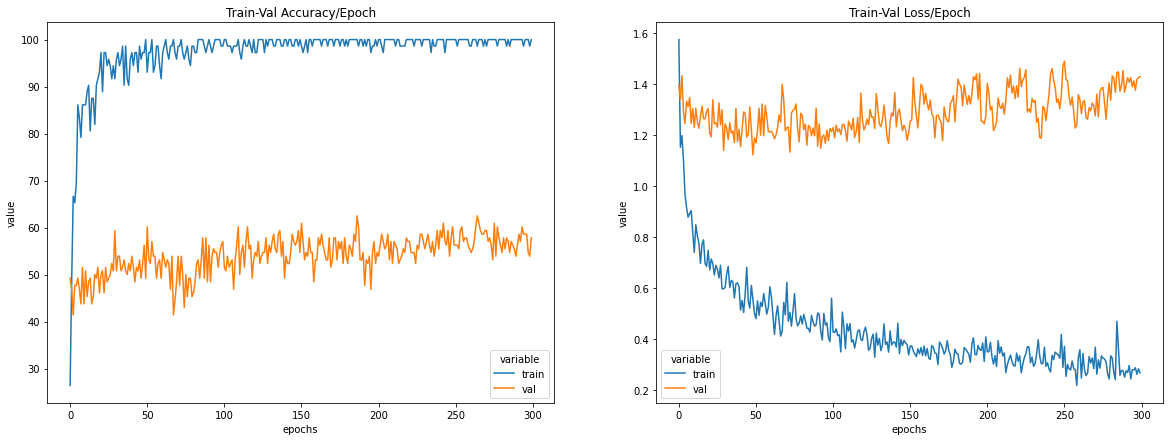

In [ ]:
# Create dataframes
train_val_acc_df = pd.DataFrame.from_dict(accuracy_stats).reset_index().melt(id_vars=['index']).rename(columns={"index":"epochs"})
train_val_loss_df = pd.DataFrame.from_dict(loss_stats).reset_index().melt(id_vars=['index']).rename(columns={"index":"epochs"})
# Plot the dataframes
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20,7))
sns.lineplot(data=train_val_acc_df, x = "epochs", y="value", hue="variable",  ax=axes[0]).set_title('Train-Val Accuracy/Epoch')
sns.lineplot(data=train_val_loss_df, x = "epochs", y="value", hue="variable", ax=axes[1]).set_title('Train-Val Loss/Epoch')

Test the model

After training is done, we need to test how our model fared. Note that we’ve used model.eval() before we run our testing code. To tell PyTorch that we do not want to perform back-propagation during inference, we use torch.no_grad(), just like we did it for the validation loop above.
We start by defining a list that will hold our predictions. Then we loop through our batches using the test_loader. For each batch —
- We move our input mini-batch to GPU.
- We make the predictions using our trained model.
- Apply log_softmax activation to the predictions and pick the index of highest probability.
- Move the batch to the GPU from the CPU.
- Convert the tensor to a numpy object and append it to our list.
- Flatten out the list so that we can use it as an input to confusion_matrix and classification_report.

`


In [ ]:
y_pred_list = []
with torch.no_grad():
    model.eval()
    for X_batch, _ in test_loader:
        X_batch = X_batch.to(device)
        y_test_pred = model(X_batch)
        y_pred_softmax = torch.log_softmax(y_test_pred, dim = 1)
        _, y_pred_tags = torch.max(y_pred_softmax, dim = 1)
        y_pred_list.append(y_pred_tags.cpu().numpy())
y_pred_list = [a.squeeze().tolist() for a in y_pred_list]

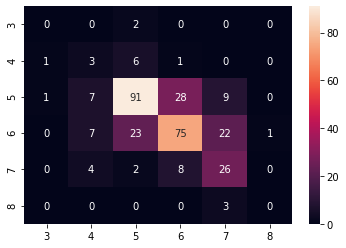

In [ ]:
confusion_matrix_df = pd.DataFrame(confusion_matrix(y_test, y_pred_list)).rename(columns=idx2class, index=idx2class)

sns.heatmap(confusion_matrix_df, annot=True)

In [ ]:
print(classification_report(y_test, y_pred_list))


              precision    recall  f1-score   support

           0       0.00      0.00      0.00         2
           1       0.14      0.27      0.19        11
           2       0.73      0.67      0.70       136
           3       0.67      0.59      0.62       128
           4       0.43      0.65      0.52        40
           5       0.00      0.00      0.00         3

    accuracy                           0.61       320
   macro avg       0.33      0.36      0.34       320
weighted avg       0.64      0.61      0.62       320



## Bench mark

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler

from sklearn.multiclass import OneVsOneClassifier,OneVsRestClassifier
from sklearn.preprocessing import MinMaxScaler,StandardScaler   
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import balanced_accuracy_score,matthews_corrcoef

from sklearn.svm import SVC
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

In [ ]:
df = pd.read_csv("/content/drive/My Drive/Data/winequality-red.csv")
print(df.shape)
df.head()

(1599, 12)


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


In [ ]:
class2idx = {
    3:0,
    4:1,
    5:2,
    6:3,
    7:4,
    8:5
}

idx2class = {v: k for k, v in class2idx.items()}

df['quality'].replace(class2idx, inplace=True)

In [ ]:
X = df.iloc[:, 0:-1]
y = df.iloc[:, -1]
# Split into train+val and test
X_trainval, X_test, y_trainval, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=69)

# Split train into train-val
X_train, X_val, y_train, y_val = train_test_split(X_trainval, y_trainval, test_size=0.1, stratify=y_trainval, random_state=21)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

In [ ]:
model=SVC() 
model.fit(X_train, y_train)
# estimate accuracy on validation dataset
y_predict = model.predict(X_test)
#y_pred_probs = model.predict_proba(X_test_tran)
confmat = confusion_matrix(y_test,y_predict)
print('balanced_accuracy_score: \n',balanced_accuracy_score(y_test, y_predict))
print('confusion_matrix \n',confmat)
print('classification_report \n',classification_report(y_test, y_predict))

balanced_accuracy_score: 
 0.2709405637254902
confusion_matrix 
 [[  0   0   1   1   0   0]
 [  0   0   9   2   0   0]
 [  0   0 104  32   0   0]
 [  0   0  47  75   6   0]
 [  0   0   4  25  11   0]
 [  0   0   0   3   0   0]]
classification_report 
               precision    recall  f1-score   support

           0       0.00      0.00      0.00         2
           1       0.00      0.00      0.00        11
           2       0.63      0.76      0.69       136
           3       0.54      0.59      0.56       128
           4       0.65      0.28      0.39        40
           5       0.00      0.00      0.00         3

    accuracy                           0.59       320
   macro avg       0.30      0.27      0.27       320
weighted avg       0.57      0.59      0.57       320



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
model=OneVsOneClassifier(SVC() )
model.fit(X_train, y_train)
# estimate accuracy on validation dataset
y_predict = model.predict(X_test)
#y_pred_probs = model.predict_proba(X_test_tran)
confmat = confusion_matrix(y_test,y_predict)
print('balanced_accuracy_score: \n',balanced_accuracy_score(y_test, y_predict))
print('confusion_matrix \n',confmat)
print('classification_report \n',classification_report(y_test, y_predict))

balanced_accuracy_score: 
 0.2723192401960784
confusion_matrix 
 [[  0   0   1   1   0   0]
 [  0   0   9   2   0   0]
 [  0   0 103  33   0   0]
 [  0   0  45  77   6   0]
 [  0   0   4  25  11   0]
 [  0   0   0   3   0   0]]
classification_report 
               precision    recall  f1-score   support

           0       0.00      0.00      0.00         2
           1       0.00      0.00      0.00        11
           2       0.64      0.76      0.69       136
           3       0.55      0.60      0.57       128
           4       0.65      0.28      0.39        40
           5       0.00      0.00      0.00         3

    accuracy                           0.60       320
   macro avg       0.30      0.27      0.27       320
weighted avg       0.57      0.60      0.57       320



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
model=XGBClassifier(random_state=42)
model.fit(X_train, y_train)
# estimate accuracy on validation dataset
y_predict = model.predict(X_test)
#y_pred_probs = model.predict_proba(X_test_tran)
confmat = confusion_matrix(y_test,y_predict)
print('balanced_accuracy_score: \n',balanced_accuracy_score(y_test, y_predict))
print('confusion_matrix \n',confmat)
print('classification_report \n',classification_report(y_test, y_predict))

balanced_accuracy_score: 
 0.2939491421568628
confusion_matrix 
 [[ 0  0  1  1  0  0]
 [ 1  0  9  1  0  0]
 [ 0  1 96 37  2  0]
 [ 0  2 35 81  9  1]
 [ 0  0  2 21 17  0]
 [ 0  0  0  3  0  0]]
classification_report 
               precision    recall  f1-score   support

           0       0.00      0.00      0.00         2
           1       0.00      0.00      0.00        11
           2       0.67      0.71      0.69       136
           3       0.56      0.63      0.60       128
           4       0.61      0.42      0.50        40
           5       0.00      0.00      0.00         3

    accuracy                           0.61       320
   macro avg       0.31      0.29      0.30       320
weighted avg       0.59      0.61      0.59       320



In [ ]:
model=LGBMClassifier(random_state=42)
model.fit(X_train, y_train)
# estimate accuracy on validation dataset
y_predict = model.predict(X_test)
#y_pred_probs = model.predict_proba(X_test_tran)
confmat = confusion_matrix(y_test,y_predict)
print('balanced_accuracy_score: \n',balanced_accuracy_score(y_test, y_predict))
print('confusion_matrix \n',confmat)
print('classification_report \n',classification_report(y_test, y_predict))

balanced_accuracy_score: 
 0.3153186274509804
confusion_matrix 
 [[  0   0   1   1   0   0]
 [  0   0   7   4   0   0]
 [  0   0 106  30   0   0]
 [  0   2  30  88   8   0]
 [  0   0   5  17  17   1]
 [  0   0   0   3   0   0]]
classification_report 
               precision    recall  f1-score   support

           0       0.00      0.00      0.00         2
           1       0.00      0.00      0.00        11
           2       0.71      0.78      0.74       136
           3       0.62      0.69      0.65       128
           4       0.68      0.42      0.52        40
           5       0.00      0.00      0.00         3

    accuracy                           0.66       320
   macro avg       0.33      0.32      0.32       320
weighted avg       0.63      0.66      0.64       320



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# Lending club classification

In [1]:
import re
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler

from sklearn.preprocessing import StandardScaler,LabelEncoder,OneHotEncoder     
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report,balanced_accuracy_score
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

In [2]:
link='https://raw.githubusercontent.com/aapatel09/handson-unsupervised-learning/master/datasets/lending_club_data/LoanStats3a.csv'
data_a=pd.read_csv(link)
print(data_a.shape)
data_a.head(2)

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (0,47) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


(42542, 145)


,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,pymnt_plan,url,desc,purpose,title,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,...,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,revol_bal_joint,sec_app_earliest_cr_line,sec_app_inq_last_6mths,sec_app_mort_acc,sec_app_open_acc,sec_app_revol_util,sec_app_open_act_il,sec_app_num_rev_accts,sec_app_chargeoff_within_12_mths,sec_app_collections_12_mths_ex_med,sec_app_mths_since_last_major_derog,hardship_flag,hardship_type,hardship_reason,hardship_status,deferral_term,hardship_amount,hardship_start_date,hardship_end_date,payment_plan_start_date,hardship_length,hardship_dpd,hardship_loan_status,orig_projected_additional_accrued_interest,hardship_payoff_balance_amount,hardship_last_payment_amount,disbursement_method,debt_settlement_flag,debt_settlement_flag_date,settlement_status,settlement_date,settlement_amount,settlement_percentage,settlement_term
0,NaN,NaN,5000.0,5000.0,4975.0,36 months,10.65%,162.87,B,B2,NaN,10+ years,RENT,24000.0,Verified,Dec-11,Fully Paid,n,NaN,Borrower added on 12/22/11 > I need to upgra...,credit_card,Computer,860xx,AZ,27.65,0.0,Jan-85,1.0,NaN,NaN,3.0,0.0,13648.0,83.70%,9.0,f,0.0,0.0,5863.155187,5833.84,...,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,2500.0,2500.0,2500.0,60 months,15.27%,59.83,C,C4,Ryder,< 1 year,RENT,30000.0,Source Verified,Dec-11,Charged Off,n,NaN,Borrower added on 12/22/11 > I plan to use t...,car,bike,309xx,GA,1.00,0.0,Apr-99,5.0,NaN,NaN,3.0,0.0,1687.0,9.40%,4.0,f,0.0,0.0,1014.530000,1014.53,...,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN


In [13]:
data_a.grade.value_counts()

B    12389
A    10183
C     8740
D     6016
E     3394
F     1301
G      512
Name: grade, dtype: int64

In [3]:
columnsToKeep = ['loan_amnt','funded_amnt','funded_amnt_inv','term', \
'int_rate','installment', \
'emp_length','home_ownership','annual_inc', \
'verification_status','pymnt_plan','purpose', \
'addr_state','dti','delinq_2yrs','earliest_cr_line', \
'mths_since_last_delinq','mths_since_last_record', \
'open_acc','pub_rec','revol_bal','revol_util', \
'total_acc','initial_list_status','out_prncp', \
'out_prncp_inv','total_pymnt','total_pymnt_inv', \
'total_rec_prncp','total_rec_int','total_rec_late_fee',
\
'recoveries','collection_recovery_fee','last_pymnt_d', \
'last_pymnt_amnt','loan_status','grade','sub_grade']
data = data_a.loc[:,columnsToKeep]
print(data.shape)
# Transform features from string to numeric
for i in ["term","int_rate","emp_length","revol_util"]:
  data.loc[:,i] = data.loc[:,i].apply(lambda x: re.sub("[^0-9]", "", str(x)))
  data.loc[:,i] = pd.to_numeric(data.loc[:,i])
print(data['last_pymnt_d'].head())
data.drop(columns='last_pymnt_d',inplace=True) 
# drop due to format is hard to change: jun-15
data.drop(columns=['mths_since_last_delinq','mths_since_last_record'],inplace=True)
# drop due to very large null
data.dropna(inplace=True)
# drop others due to small, no need to impute
data.drop(columns='earliest_cr_line',inplace=True) 
# drop due to format is hard to change: jun-15
X=data.drop(columns='grade')
y=data['grade']
print(X.shape,y.shape)

(42542, 38)
0    Jan-15
1    Apr-13
2    Jun-14
3    Jan-15
4    Jan-17
Name: last_pymnt_d, dtype: object
(41336, 33) (41336,)


In [4]:
X.drop(columns=['pymnt_plan','initial_list_status'],inplace=True)
# drop due to only 1 value
X.drop(columns='sub_grade',inplace=True)
one_hot_encoder=X.select_dtypes(include='object').columns
data_dummy=pd.get_dummies(X.loc[:,one_hot_encoder])
data_dummy=data_dummy.astype('int64')
X.drop(columns=one_hot_encoder,inplace=True)
X=pd.concat([data_dummy,X,],axis=1)
lab=LabelEncoder()
y=lab.fit_transform(y)

In [5]:
# Split into train+val and test
X_trainval, X_test, y_trainval, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=69)

# Split train into train-val
X_train, X_val, y_train, y_val = train_test_split(X_trainval, y_trainval, test_size=0.1, stratify=y_trainval, random_state=21)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

X_train, y_train = np.array(X_train), np.array(y_train)
X_val, y_val = np.array(X_val), np.array(y_val)
X_test, y_test = np.array(X_test), np.array(y_test)

In [6]:
X_train.shape,y_train.shape

((29761, 101), (29761,))

## Benchmark

In [38]:
%%time
model=XGBClassifier(random_state=42)
model.fit(X_train, y_train)
# estimate accuracy on validation dataset
y_predict = model.predict(X_test)
#y_pred_probs = model.predict_proba(X_test_tran)
print('balanced_accuracy_score: \n',balanced_accuracy_score(y_test, y_predict))
print('classification_report \n',classification_report(y_test, y_predict))

balanced_accuracy_score: 
 0.8439090855471865
classification_report 
               precision    recall  f1-score   support

           0       0.99      0.99      0.99      1956
           1       0.96      0.99      0.98      2407
           2       0.93      0.95      0.94      1708
           3       0.85      0.91      0.88      1175
           4       0.86      0.74      0.80       666
           5       0.87      0.63      0.73       255
           6       0.92      0.69      0.79       101

    accuracy                           0.94      8268
   macro avg       0.91      0.84      0.87      8268
weighted avg       0.94      0.94      0.93      8268

CPU times: user 49.2 s, sys: 32.3 ms, total: 49.2 s
Wall time: 49.3 s


In [39]:
%%time
model=LGBMClassifier(random_state=42)
model.fit(X_train, y_train)
# estimate accuracy on validation dataset
y_predict = model.predict(X_test)
#y_pred_probs = model.predict_proba(X_test_tran)
print('balanced_accuracy_score: \n',balanced_accuracy_score(y_test, y_predict))
print('classification_report \n',classification_report(y_test, y_predict))

balanced_accuracy_score: 
 0.9121630575810187
classification_report 
               precision    recall  f1-score   support

           0       1.00      0.99      0.99      1956
           1       0.99      0.99      0.99      2407
           2       0.98      0.98      0.98      1708
           3       0.91      0.95      0.93      1175
           4       0.90      0.86      0.88       666
           5       0.88      0.79      0.83       255
           6       0.95      0.81      0.88       101

    accuracy                           0.97      8268
   macro avg       0.94      0.91      0.93      8268
weighted avg       0.97      0.97      0.97      8268

CPU times: user 14.7 s, sys: 69.8 ms, total: 14.7 s
Wall time: 14.8 s


## Neural net

In [10]:
class ClassifierDataset(Dataset):
    
    def __init__(self, X_data, y_data):
        self.X_data = X_data
        self.y_data = y_data
        
    def __getitem__(self, index):
        return self.X_data[index], self.y_data[index]
        
    def __len__ (self):
        return len(self.X_data)

train_dataset = ClassifierDataset(torch.from_numpy(X_train).float(), torch.from_numpy(y_train).long())
val_dataset = ClassifierDataset(torch.from_numpy(X_val).float(), torch.from_numpy(y_val).long())
test_dataset = ClassifierDataset(torch.from_numpy(X_test).float(), torch.from_numpy(y_test).long())

In [11]:
#First, we obtain a list called target_list which contains all our outputs.
#This list is then converted to a tensor and shuffled.
target_list = []
for _, t in train_dataset:
    target_list.append(t)
    
target_list = torch.tensor(target_list)
target_list = target_list[torch.randperm(len(target_list))]
print(target_list.shape)
target_list

torch.Size([29761])


tensor([2, 1, 1,  ..., 2, 0, 1])

In [21]:
list(lab.classes_)

['A', 'B', 'C', 'D', 'E', 'F', 'G']

In [23]:
list(lab.inverse_transform([2, 2, 1]))

['C', 'C', 'B']

In [26]:
class_count=list(pd.Series(y_train).value_counts().sort_index())
class_count

[7040, 8662, 6148, 4231, 2399, 916, 365]

In [27]:
class_weights = 1./torch.tensor(class_count, dtype=torch.float) 
print(class_weights)

tensor([0.0001, 0.0001, 0.0002, 0.0002, 0.0004, 0.0011, 0.0027])


In [28]:
#WeightedRandomSampler expects a weight for each sample. We do that using as follows.
class_weights_all = class_weights[target_list]
print(class_weights_all.shape)
class_weights_all

torch.Size([29761])


tensor([0.0002, 0.0001, 0.0001,  ..., 0.0002, 0.0001, 0.0001])

In [29]:
weighted_sampler = WeightedRandomSampler(
    weights=class_weights_all,
    num_samples=len(class_weights_all),
    replacement=True
)
weighted_sampler

In [49]:
EPOCHS = 25
BATCH_SIZE = 300
LEARNING_RATE = 0.0007
NUM_FEATURES = len(X.columns)
NUM_CLASSES = len(class_count)

In [50]:
train_loader = DataLoader(dataset=train_dataset,
                          batch_size=BATCH_SIZE,
                          sampler=weighted_sampler
                          )
val_loader = DataLoader(dataset=val_dataset, batch_size=1)
test_loader = DataLoader(dataset=test_dataset, batch_size=1)

In [51]:
class MulticlassClassification(nn.Module):
    def __init__(self, num_feature, num_class):
        super(MulticlassClassification, self).__init__()
        
        self.layer_1 = nn.Linear(num_feature, 512)
        self.layer_2 = nn.Linear(512, 128)
        self.layer_3 = nn.Linear(128, 64)
        self.layer_out = nn.Linear(64, num_class) 
        
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=0.2)
        self.batchnorm1 = nn.BatchNorm1d(512)
        self.batchnorm2 = nn.BatchNorm1d(128)
        self.batchnorm3 = nn.BatchNorm1d(64)
        
    def forward(self, x):
        x = self.layer_1(x)
        x = self.batchnorm1(x)
        x = self.relu(x)
        
        x = self.layer_2(x)
        x = self.batchnorm2(x)
        x = self.relu(x)
        x = self.dropout(x)
        
        x = self.layer_3(x)
        x = self.batchnorm3(x)
        x = self.relu(x)
        x = self.dropout(x)
        
        x = self.layer_out(x)
        
        return x

In [52]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
model = MulticlassClassification(num_feature = NUM_FEATURES, num_class=NUM_CLASSES)
model.to(device)

criterion = nn.CrossEntropyLoss(weight=class_weights.to(device))
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
print(model)

cpu
MulticlassClassification(
  (layer_1): Linear(in_features=101, out_features=512, bias=True)
  (layer_2): Linear(in_features=512, out_features=128, bias=True)
  (layer_3): Linear(in_features=128, out_features=64, bias=True)
  (layer_out): Linear(in_features=64, out_features=7, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.2, inplace=False)
  (batchnorm1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm3): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)


In [53]:
def multi_acc(y_pred, y_test):
    y_pred_softmax = torch.log_softmax(y_pred, dim = 1)
    _, y_pred_tags = torch.max(y_pred_softmax, dim = 1)    
    
    correct_pred = (y_pred_tags == y_test).float()
    acc = correct_pred.sum() / len(correct_pred)
    
    acc = torch.round(acc) * 100
    
    return acc

In [54]:
accuracy_stats = {
    'train': [],
    "val": []
}
loss_stats = {
    'train': [],
    "val": []
}

In [55]:
print("Begin training.")
for e in tqdm(range(1, EPOCHS+1)):
    
    # TRAINING
    train_epoch_loss = 0
    train_epoch_acc = 0
    model.train()
    for X_train_batch, y_train_batch in train_loader:
        X_train_batch, y_train_batch = X_train_batch.to(device), y_train_batch.to(device)
        optimizer.zero_grad()
        
        y_train_pred = model(X_train_batch)
        
        train_loss = criterion(y_train_pred, y_train_batch)
        train_acc = multi_acc(y_train_pred, y_train_batch)
        
        train_loss.backward()
        optimizer.step()
        
        train_epoch_loss += train_loss.item()
        train_epoch_acc += train_acc.item()
        
        
    # VALIDATION    
    with torch.no_grad():
        
        val_epoch_loss = 0
        val_epoch_acc = 0
        
        model.eval()
        for X_val_batch, y_val_batch in val_loader:
            X_val_batch, y_val_batch = X_val_batch.to(device), y_val_batch.to(device)
            
            y_val_pred = model(X_val_batch)
                        
            val_loss = criterion(y_val_pred, y_val_batch)
            val_acc = multi_acc(y_val_pred, y_val_batch)
            
            val_epoch_loss += val_loss.item()
            val_epoch_acc += val_acc.item()
    loss_stats['train'].append(train_epoch_loss/len(train_loader))
    loss_stats['val'].append(val_epoch_loss/len(val_loader))
    accuracy_stats['train'].append(train_epoch_acc/len(train_loader))
    accuracy_stats['val'].append(val_epoch_acc/len(val_loader))
                              
    
    print(f'Epoch {e+0:03}: | Train Loss: {train_epoch_loss/len(train_loader):.5f} | Val Loss: {val_epoch_loss/len(val_loader):.5f} | Train Acc: {train_epoch_acc/len(train_loader):.3f}| Val Acc: {val_epoch_acc/len(val_loader):.3f}')

Begin training.


Epoch 001: | Train Loss: 1.43908 | Val Loss: 1.11576 | Train Acc: 33.000| Val Acc: 57.877
Epoch 002: | Train Loss: 0.94785 | Val Loss: 0.71228 | Train Acc: 100.000| Val Acc: 74.660
Epoch 003: | Train Loss: 0.73251 | Val Loss: 0.59339 | Train Acc: 100.000| Val Acc: 76.807
Epoch 004: | Train Loss: 0.64243 | Val Loss: 0.51184 | Train Acc: 100.000| Val Acc: 79.044
Epoch 005: | Train Loss: 0.56760 | Val Loss: 0.49298 | Train Acc: 100.000| Val Acc: 78.984
Epoch 006: | Train Loss: 0.53025 | Val Loss: 0.47512 | Train Acc: 100.000| Val Acc: 79.952
Epoch 007: | Train Loss: 0.49988 | Val Loss: 0.46647 | Train Acc: 100.000| Val Acc: 79.831
Epoch 008: | Train Loss: 0.49482 | Val Loss: 0.46758 | Train Acc: 100.000| Val Acc: 79.528
Epoch 009: | Train Loss: 0.44624 | Val Loss: 0.45539 | Train Acc: 100.000| Val Acc: 79.800
Epoch 010: | Train Loss: 0.43492 | Val Loss: 0.48577 | Train Acc: 100.000| Val Acc: 79.468
Epoch 011: | Train Loss: 0.42731 | Val Loss: 0.46458 | Train Acc: 100.000| Val Acc: 79.649


Text(0.5, 1.0, 'Train-Val Loss/Epoch')

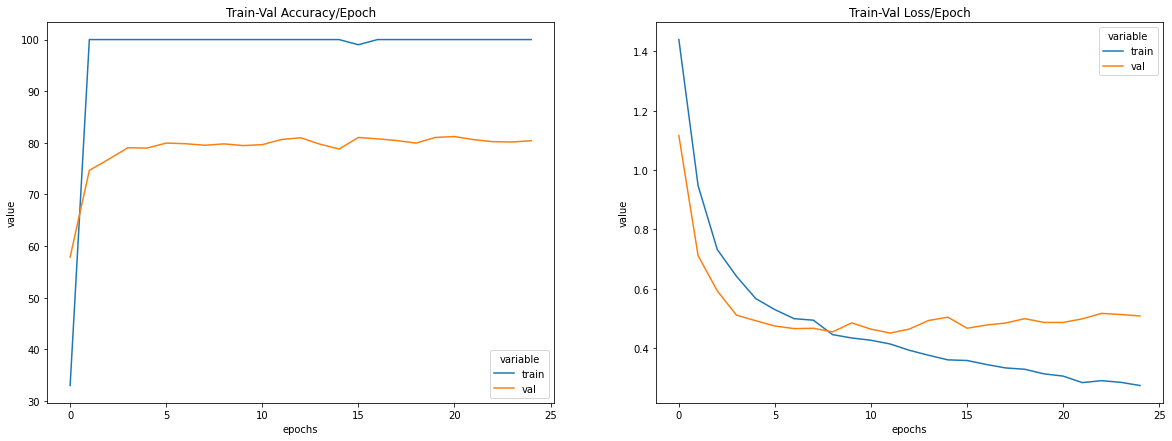

In [56]:
# Create dataframes
train_val_acc_df = pd.DataFrame.from_dict(accuracy_stats).reset_index().melt(id_vars=['index']).rename(columns={"index":"epochs"})
train_val_loss_df = pd.DataFrame.from_dict(loss_stats).reset_index().melt(id_vars=['index']).rename(columns={"index":"epochs"})
# Plot the dataframes
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20,7))
sns.lineplot(data=train_val_acc_df, x = "epochs", y="value", hue="variable",  ax=axes[0]).set_title('Train-Val Accuracy/Epoch')
sns.lineplot(data=train_val_loss_df, x = "epochs", y="value", hue="variable", ax=axes[1]).set_title('Train-Val Loss/Epoch')

In [57]:
y_pred_list = []
with torch.no_grad():
    model.eval()
    for X_batch, _ in test_loader:
        X_batch = X_batch.to(device)
        y_test_pred = model(X_batch)
        y_pred_softmax = torch.log_softmax(y_test_pred, dim = 1)
        _, y_pred_tags = torch.max(y_pred_softmax, dim = 1)
        y_pred_list.append(y_pred_tags.cpu().numpy())
y_pred_list = [a.squeeze().tolist() for a in y_pred_list]

In [58]:
print('balanced_accuracy_score: \n',balanced_accuracy_score(y_test, y_pred_list))
print('classification_report \n',classification_report(y_test, y_pred_list))

balanced_accuracy_score: 
 0.6810666049430488
classification_report 
               precision    recall  f1-score   support

           0       0.97      0.96      0.96      1956
           1       0.92      0.89      0.91      2407
           2       0.79      0.81      0.80      1708
           3       0.67      0.69      0.68      1175
           4       0.54      0.54      0.54       666
           5       0.39      0.44      0.41       255
           6       0.52      0.44      0.48       101

    accuracy                           0.82      8268
   macro avg       0.69      0.68      0.68      8268
weighted avg       0.82      0.82      0.82      8268



## Neural net 2

In [63]:
EPOCHS = 100
BATCH_SIZE = 300
LEARNING_RATE = 0.0007
NUM_FEATURES = len(X.columns)
NUM_CLASSES = len(class_count)

In [64]:
class MulticlassClassification(nn.Module):
    def __init__(self, num_feature, num_class):
        super(MulticlassClassification, self).__init__()
        
        self.layer_1 = nn.Linear(num_feature, 20)
        self.layer_out = nn.Linear(20, num_class) 
        
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=0.2)
        self.batchnorm1 = nn.BatchNorm1d(20)

        
    def forward(self, x):
        x = self.layer_1(x)
        x = self.batchnorm1(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.layer_out(x)
        
        return x

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
model = MulticlassClassification(num_feature = NUM_FEATURES, num_class=NUM_CLASSES)
model.to(device)

criterion = nn.CrossEntropyLoss(weight=class_weights.to(device))
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
print(model)

def multi_acc(y_pred, y_test):
    y_pred_softmax = torch.log_softmax(y_pred, dim = 1)
    _, y_pred_tags = torch.max(y_pred_softmax, dim = 1)    
    
    correct_pred = (y_pred_tags == y_test).float()
    acc = correct_pred.sum() / len(correct_pred)
    
    acc = torch.round(acc) * 100
    
    return acc

cpu
MulticlassClassification(
  (layer_1): Linear(in_features=101, out_features=20, bias=True)
  (layer_out): Linear(in_features=20, out_features=7, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.2, inplace=False)
  (batchnorm1): BatchNorm1d(20, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)


In [65]:
accuracy_stats = {
    'train': [],
    "val": []
}
loss_stats = {
    'train': [],
    "val": []
}
print("Begin training.")
for e in tqdm(range(1, EPOCHS+1)):
    
    # TRAINING
    train_epoch_loss = 0
    train_epoch_acc = 0
    model.train()
    for X_train_batch, y_train_batch in train_loader:
        X_train_batch, y_train_batch = X_train_batch.to(device), y_train_batch.to(device)
        optimizer.zero_grad()
        
        y_train_pred = model(X_train_batch)
        
        train_loss = criterion(y_train_pred, y_train_batch)
        train_acc = multi_acc(y_train_pred, y_train_batch)
        
        train_loss.backward()
        optimizer.step()
        
        train_epoch_loss += train_loss.item()
        train_epoch_acc += train_acc.item()
        
        
    # VALIDATION    
    with torch.no_grad():
        
        val_epoch_loss = 0
        val_epoch_acc = 0
        
        model.eval()
        for X_val_batch, y_val_batch in val_loader:
            X_val_batch, y_val_batch = X_val_batch.to(device), y_val_batch.to(device)
            
            y_val_pred = model(X_val_batch)
                        
            val_loss = criterion(y_val_pred, y_val_batch)
            val_acc = multi_acc(y_val_pred, y_val_batch)
            
            val_epoch_loss += val_loss.item()
            val_epoch_acc += val_acc.item()
    loss_stats['train'].append(train_epoch_loss/len(train_loader))
    loss_stats['val'].append(val_epoch_loss/len(val_loader))
    accuracy_stats['train'].append(train_epoch_acc/len(train_loader))
    accuracy_stats['val'].append(val_epoch_acc/len(val_loader))
                              
    
    print(f'Epoch {e+0:03}: | Train Loss: {train_epoch_loss/len(train_loader):.5f} | Val Loss: {val_epoch_loss/len(val_loader):.5f} | Train Acc: {train_epoch_acc/len(train_loader):.3f}| Val Acc: {val_epoch_acc/len(val_loader):.3f}')

Begin training.


Epoch 001: | Train Loss: 1.89642 | Val Loss: 1.80272 | Train Acc: 0.000| Val Acc: 31.055
Epoch 002: | Train Loss: 1.66952 | Val Loss: 1.58718 | Train Acc: 0.000| Val Acc: 40.187
Epoch 003: | Train Loss: 1.48184 | Val Loss: 1.37425 | Train Acc: 1.000| Val Acc: 47.626
Epoch 004: | Train Loss: 1.33006 | Val Loss: 1.21748 | Train Acc: 51.000| Val Acc: 55.670
Epoch 005: | Train Loss: 1.22555 | Val Loss: 1.09915 | Train Acc: 98.000| Val Acc: 62.292
Epoch 006: | Train Loss: 1.15542 | Val Loss: 1.00331 | Train Acc: 100.000| Val Acc: 67.221
Epoch 007: | Train Loss: 1.08465 | Val Loss: 0.93401 | Train Acc: 100.000| Val Acc: 69.035
Epoch 008: | Train Loss: 1.04164 | Val Loss: 0.86861 | Train Acc: 100.000| Val Acc: 72.815
Epoch 009: | Train Loss: 0.99395 | Val Loss: 0.81778 | Train Acc: 100.000| Val Acc: 74.902
Epoch 010: | Train Loss: 0.95437 | Val Loss: 0.77690 | Train Acc: 100.000| Val Acc: 75.023
Epoch 011: | Train Loss: 0.93458 | Val Loss: 0.74568 | Train Acc: 100.000| Val Acc: 75.627
Epoch 0

Text(0.5, 1.0, 'Train-Val Loss/Epoch')

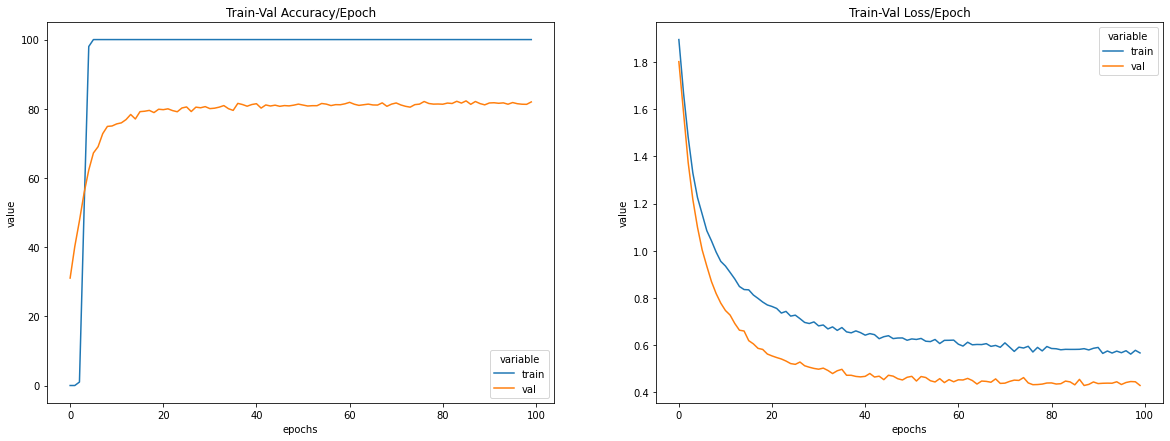

In [66]:
# Create dataframes
train_val_acc_df = pd.DataFrame.from_dict(accuracy_stats).reset_index().melt(id_vars=['index']).rename(columns={"index":"epochs"})
train_val_loss_df = pd.DataFrame.from_dict(loss_stats).reset_index().melt(id_vars=['index']).rename(columns={"index":"epochs"})
# Plot the dataframes
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20,7))
sns.lineplot(data=train_val_acc_df, x = "epochs", y="value", hue="variable",  ax=axes[0]).set_title('Train-Val Accuracy/Epoch')
sns.lineplot(data=train_val_loss_df, x = "epochs", y="value", hue="variable", ax=axes[1]).set_title('Train-Val Loss/Epoch')

In [67]:
y_pred_list = []
with torch.no_grad():
    model.eval()
    for X_batch, _ in test_loader:
        X_batch = X_batch.to(device)
        y_test_pred = model(X_batch)
        y_pred_softmax = torch.log_softmax(y_test_pred, dim = 1)
        _, y_pred_tags = torch.max(y_pred_softmax, dim = 1)
        y_pred_list.append(y_pred_tags.cpu().numpy())
y_pred_list = [a.squeeze().tolist() for a in y_pred_list]
print('balanced_accuracy_score: \n',balanced_accuracy_score(y_test, y_pred_list))
print('classification_report \n',classification_report(y_test, y_pred_list))

balanced_accuracy_score: 
 0.7112947804523608
classification_report 
               precision    recall  f1-score   support

           0       0.97      0.98      0.97      1956
           1       0.94      0.92      0.93      2407
           2       0.82      0.84      0.83      1708
           3       0.69      0.68      0.68      1175
           4       0.56      0.50      0.53       666
           5       0.40      0.52      0.46       255
           6       0.46      0.54      0.50       101

    accuracy                           0.83      8268
   macro avg       0.69      0.71      0.70      8268
weighted avg       0.83      0.83      0.83      8268

